그런즉 너희는 먼저 그의 나라와 그의 의를 구하라 그리하면 이 모든 것을 너희에게 더하시리라 그러므로 내일 일을 위하여 염려하지 말라 내일 일은 내일이 염려할 것이요 한 날의 괴로움은 그 날로 족하니라 (마6:33-34)
<center><img src="https://github.com/idebtor/KMOOC-ML/blob/master/ipynb/images/MLwithPython.png?raw=true" width=1000></center>

__NOTE:__ The following materials have been compiled and adapted from the numerous sources including my own. Please help me to keep this tutorial up-to-date by reporting any issues or questions. Send any comments or criticisms to `idebtor@gmail.com` Your assistances and comments will be appreciated.

# 제 13-1 강: Deep Neural Net Test

## 학습 목표
- 딥뉴럴넷 클래스에 배치 경사하강법을 구현한다. 
- 다양한 데이터셋을 이용하여 딥뉴럴넷의 성능을 테스트한다. 

## 학습 내용
- 딥뉴럴넷 클래스에 배치 경사하강법 구현하기 
- MNIST-Fashion DataSet 다루기
- 고양이 인식 문제 도전하기


In [1]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
# Our own private imports
import imp
import joy
imp.reload(joy)

%matplotlib inline
np.random.seed(1)   # a good practice for reproducibility and debugging

# The following code is used for hiding the warnings and 
# make this notebook clearer.
#import warnings
#warnings.filterwarnings('ignore')

# Guassian_Quantiles() using BGD

In [2]:
def tanh(x):
    return (1.0 - np.exp(-2*x))/(1.0 + np.exp(-2*x))

def tanh_d(x):
    return (1 + tanh(x))*(1 - tanh(x))

def sigmoid(x): 
    x = np.clip(x, -500, 500)  
    return 1/(1 + np.exp((-x)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x, 0)

def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [3]:
#%%writefile code/DeepNerualNet_BGD.py
#%load code/DeepNeuralNet_BGD.py
class DeepNeuralNet_BGD(object):
    """ implements a deep neural net. 
        Users may specify any number of layers.
        net_arch -- consists of a number of neurons in each layer 
    """
    def __init__(self, net_arch, activate = None, eta = 1.0, epochs = 100, random_seed = 1):
        
        if not isinstance(net_arch, list):
            sys.exit('Use a list to list number of neurons in each layer.')
        if len(net_arch) < 3:
            sys.exit('Specify the number of neurons more than two layers.')
                     
        self.eta = eta
        self.epochs = epochs
        self.net_arch = net_arch
        self.layers = len(net_arch)
        self.W = []
        self.random_seed = random_seed
        
        np.random.seed(self.random_seed)
        # Random initialization with range of weight values (-1,1)
        # A place holder None is used to indicated "unused place".
        self.W = [[None]]    ## the first W0 is not used.
        for layer in range(self.layers - 1):
            w = 2 * np.random.rand(self.net_arch[layer+1], 
                                   self.net_arch[layer]) - 1
            self.W.append(w)
        
        # initialize the activation function list with sigmoid() as default
        self.g = [lambda x: sigmoid(x) for _ in range(self.layers)]
        self.g_prime = [lambda x: sigmoid_d(x) for _ in range(self.layers)]
        
        # get the user-defined activation functions and their derivatives
        if activate is not None:
            if len(activate) % 2 != 0:
                sys.exit("List activation functions & its derivatives in pairwise")
            if len(activate) > (self.layers - 1) * 2:
                sys.exit("Too many activation functions & its derivatives encountered")
            for i, (g, g_prime) in enumerate(zip(activate[::2], activate[1::2])):
                self.g[i+1] = g
                self.g_prime[i+1] = g_prime
            
    def forpass(self, A0):     
        Z = [[None]] # Z0 is not used.
        A = []       # A0 = X0 is used. 
        A.append(A0)
        for i in range(1, len(self.W)):
            z = np.dot(self.W[i], A[i-1])
            Z.append(z)
            a = self.g[i](z)
            A.append(a)
        return Z, A
    
    def backprop(self, Z, A, Y):
        # initialize empty lists to save E and dZ
        # A place holder None is used to indicated "unused place".
        E  = [None for x in range(self.layers)]
        dZ = [None for x in range(self.layers)]
        
        # Get error at the output layer or the last layer
        ll = self.layers - 1
        error = Y - A[ll]
        E[ll] = error   
        dZ[ll] = error * self.g_prime[ll](Z[ll]) 
        
        # Begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            E[i]  = np.dot(self.W[i+1].T, E[i+1])
            dZ[i] = E[i] * self.g_prime[i](Z[i])
       
        # Adjust the weights 
        m = Y.shape[1]  # number of samples
        for i in range(ll, 0, -1):
            self.W[i] += self.eta * np.dot(dZ[i], A[i-1].T) / m
        return error
         
    def fit(self, X, y):
        self.cost_ = [] 
        self.m_samples = len(y)
        Y = joy.one_hot_encoding(y, self.net_arch[-1]) 
        
        for epoch in range(self.epochs): 
            #if epoch % 20== 0:
            #    print('Training epoch {}/{}'.format(epoch+1, self.epochs))

            A0 = np.array(X, ndmin=2).T   # A0 : inputs, minimum 2d array
            Y0 = np.array(Y, ndmin=2).T   # Y: targets

            Z, A = self.forpass(A0)          # forward pass
            cost = self.backprop(Z, A, Y0)   # back propagation
            self.cost_.append(np.sqrt(np.sum(cost * cost)))
        return self

    def predict(self, X):  # used in plot_decsion_regions()          
        Z, A2 = self.forpass(X)
        A2 = np.array(A2[len(A2)-1])
        return A2[-1] > 0.5
    
    def predict_(self, X): # used in evaluate() 
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z, A = self.forpass(A0)             # forpass
        return A[-1]                                       
   
    def evaluate(self, Xtest, ytest):       # fully vectorized calculation
        m_samples = len(ytest)
        scores = 0        
        A3 = self.predict_(Xtest)
        yhat = np.argmax(A3, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

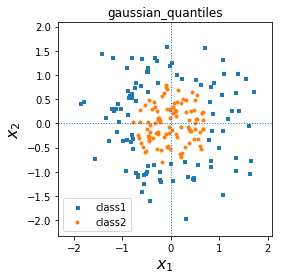

In [4]:
import joy
x, y = joy.gaussian_quantiles(random_seed = 0)
joy.plot_xyw(x.T, y.squeeze(), title="gaussian_quantiles")

In [7]:
import joy
X, Y = joy.gaussian_quantiles(random_seed=1)
nn1 = DeepNeuralNet_BGD([2, 100,2], eta=0.2, epochs=2000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))

Accuracy 55.50000000000001%


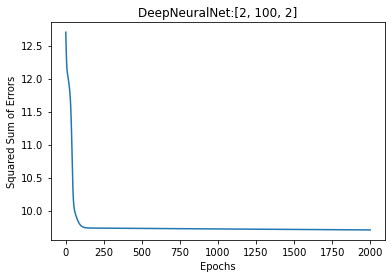

In [8]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()

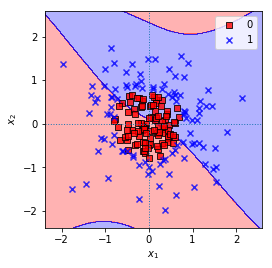

In [8]:
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn1.predict(z.T))

In [11]:
import joy
X, Y = joy.gaussian_quantiles(random_seed = 1)
nn2 = DeepNeuralNet_BGD([2, 100,50,20, 2], eta=0.2, epochs=2000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 99.5%


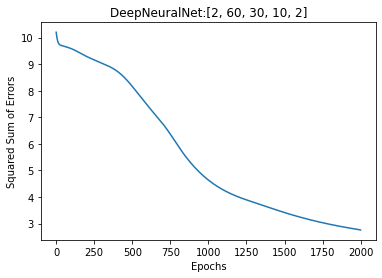

In [10]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

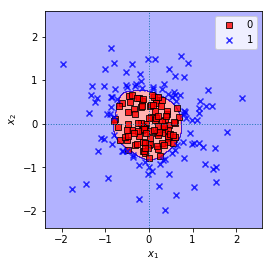

In [11]:
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn2.predict(z.T))

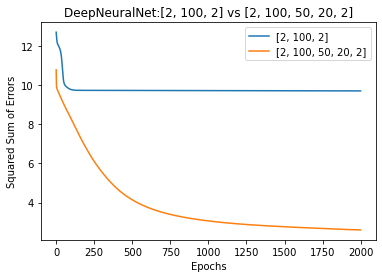

In [12]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

#  Blobs using BGD

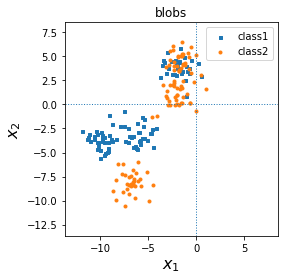

In [14]:
import joy
%matplotlib inline
X, Y = joy.blobs()
joy.plot_xyw(X.T, Y.squeeze(), title="blobs")

In [15]:
X, Y = joy.blobs()
nn1 = DeepNeuralNet_BGD([2, 100, 2], eta=0.2, epochs=2000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))

joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn1.predict(z.T))

Accuracy 84.0%


KeyboardInterrupt: 

In [ ]:
X, Y = joy.blobs()
nn2 = DeepNeuralNet_BGD([2, 100, 50, 20, 2], eta=0.2, epochs=2000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print("Accuracy {}%".format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), lambda z: nn2.predict(z.T))

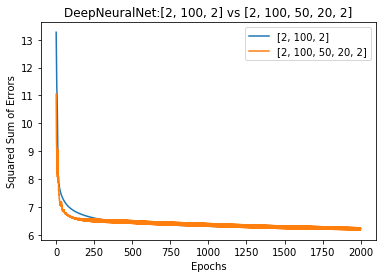

In [8]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

# Noisy_moons() using BGD

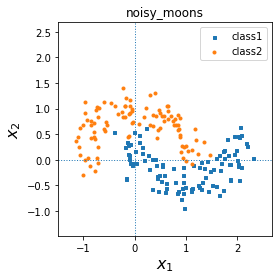

In [16]:
import joy
%matplotlib inline
X, Y = joy.noisy_moons()
joy.plot_xyw(X.T, Y.squeeze(), title="noisy_moons")

Accuracy 86.5%


/Users/yunyoung/Documents/GitHub/KMOOCX/ipynb/joy.py:890: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],


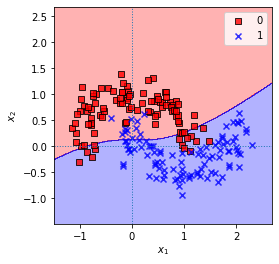

In [17]:
X, Y = joy.noisy_moons()
nn1 = DeepNeuralNet_BGD([2, 200, 2], eta=0.2, epochs=5000)
nn1.fit(X.T, Y.flatten())
accuracy = nn1.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), 
                          lambda z: nn1.predict(z.T))

Accuracy 96.5%


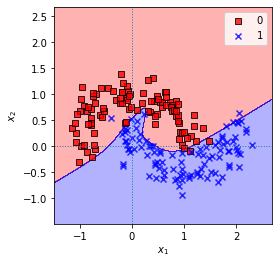

In [18]:
X, Y = joy.noisy_moons()
nn2 = DeepNeuralNet_BGD([2,100,50,20, 2], eta=0.2, epochs=5000)
nn2.fit(X.T, Y.flatten())
accuracy = nn2.evaluate(X.T, Y.flatten())
print('Accuracy {}%'.format(accuracy))
joy.plot_decision_regions(X.T, Y.squeeze(), 
                          lambda z: nn2.predict(z.T))

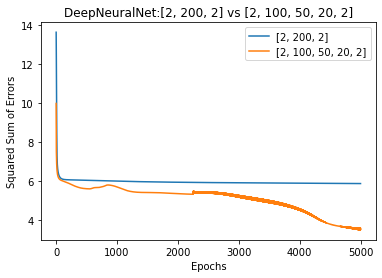

In [19]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

In [10]:
X,Y=joy.noisy_moons()
accuracies=[]
count=0
for hnode in range(100,300,20):
    for epoch in range(200,1000,100):
        nn1=DeepNeuralNet_BGD([2,hnode,2],eta=0.2,epochs=epoch)
        nn1.fit(X.T,Y.flatten())
        accuracy=nn1.evaluate(X.T,Y.flatten())
        accuracies.append((np.round(accuracy,1),hnode,epoch))

        accuracies.sort(key=lambda tup: tup[0])
        count+=1
        
        '''
        print(accuracies[:4])
        print(accuracies[-4:])
        print('Max Accuracy:',accuracies[-1])
        print('Max Accuracy {}% at (hnode,epoch)=({},{})'.format(
              accuracies[-1][0],accuracies[-1][1],accuracies[-1][2]))
              '''
print(count)

80


# Planar_data() using BGD

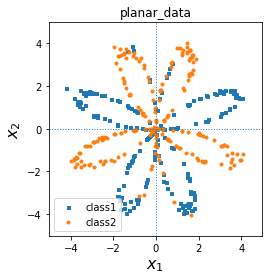

In [20]:
import joy
X, Y = joy.planar_data()
joy.plot_xyw(X.T, Y.squeeze(), title="planar_data")

In [21]:
import joy
X, y = joy.planar_data()
nn1 = DeepNeuralNet_BGD([2, 200, 2], 
                        eta=0.3, epochs=5000)
nn1.fit(X.T, y.flatten())
accuracy = nn1.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 87.5%


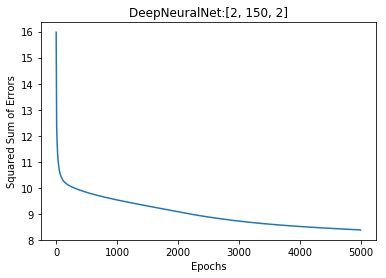

In [91]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()

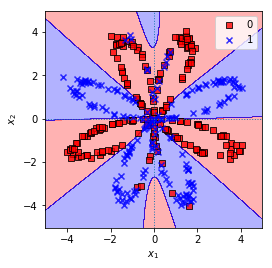

In [92]:
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn1.predict(z.T))

In [22]:
import joy
X, y = joy.planar_data()
nn2 = DeepNeuralNet_BGD([2, 100,50,20, 2], 
                        eta=0.2, epochs=5000)
nn2.fit(X.T, y.flatten())
accuracy = nn2.evaluate(X.T, y.flatten())
print("Accuracy {}%".format(accuracy))

Accuracy 91.0%


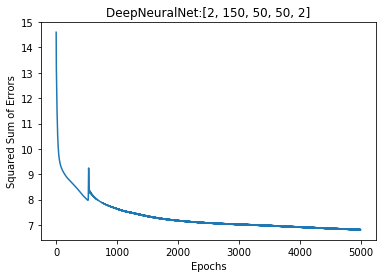

In [94]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

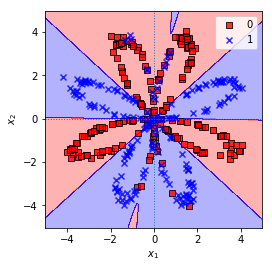

In [95]:
joy.plot_decision_regions(X.T, y.squeeze(), lambda z: nn2.predict(z.T))

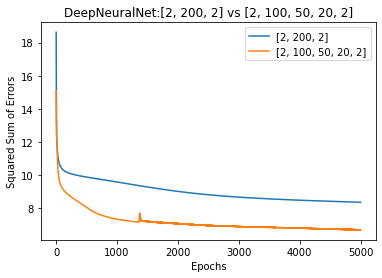

In [23]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

# MNIST-Fashion DataSet using BGD

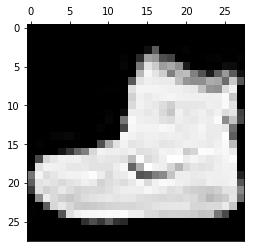

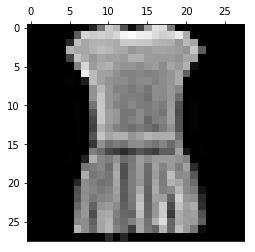

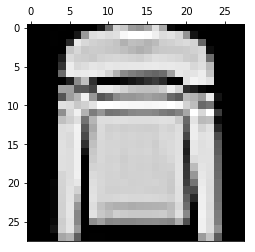

In [2]:
import joy
import matplotlib.pyplot as plt
(X, y), (Xt, yt) = joy.load_fashion_mnist(
                normalize=False, flatten=False)
joy.show_mnist(X[0])
joy.show_mnist(X[3])
joy.show_mnist(X[5])

In [60]:
(X, y), (Xtest, ytest) = joy.load_fashion_mnist()     
nn1 = DeepNeuralNet_BGD([784, 100, 10], 
                       eta = 0.1, epochs = 1000)  
nn1.fit(X[:6000], y[:6000])
accuracy = nn1.evaluate(Xtest[:1000], ytest[:1000])
print('Accuracy {}%'.format(accuracy))

Accuracy 75.6%


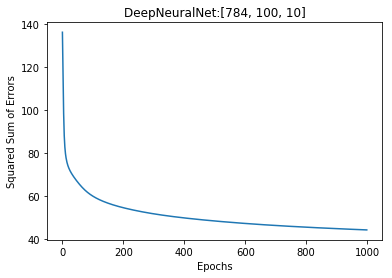

In [61]:
plt.plot(range(len(nn1.cost_)), nn1.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn1.net_arch))
plt.show()

In [62]:
(X, y), (Xtest, ytest) = joy.load_fashion_mnist()     
nn2 = DeepNeuralNet_BGD([784, 200, 100, 50, 10],
                       eta = 0.1, epochs = 1000)  
nn2.fit(X[:6000], y[:6000])
accuracy = nn2.evaluate(Xtest[:1000], ytest[:1000])
print('Accuracy {}%'.format(accuracy))

Accuracy 83.2%


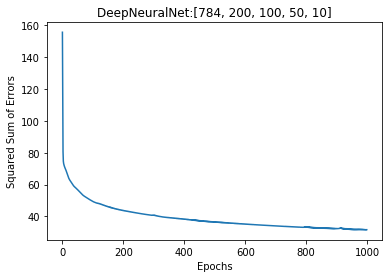

In [63]:
plt.plot(range(len(nn2.cost_)), nn2.cost_)
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.title('DeepNeuralNet:{}'.format(nn2.net_arch))
plt.show()

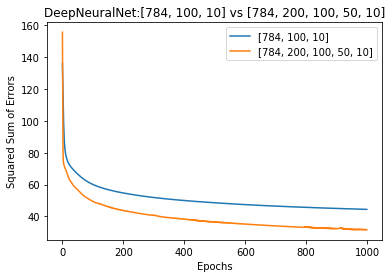

In [64]:
plt.plot(range(len(nn1.cost_)), nn1.cost_, label='{}'.format(nn1.net_arch))
plt.plot(range(len(nn2.cost_)), nn2.cost_, label='{}'.format(nn2.net_arch))
plt.title('DeepNeuralNet:{} vs {}'.format(nn1.net_arch, nn2.net_arch))
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

# Cat vs Non-Cat using BGD

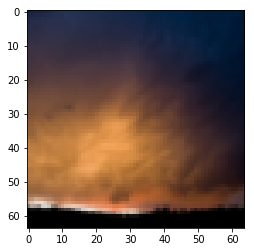

In [5]:
import joy
X, y, Xtest, ytest, classes = joy.load_cat_data()
plt.imshow(X[0]) 

In [6]:
print(classes)
print(classes.shape)

[b'non-cat' b'cat']
(2,)


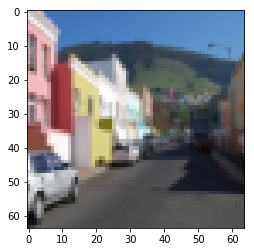

In [7]:
plt.imshow(X[1])

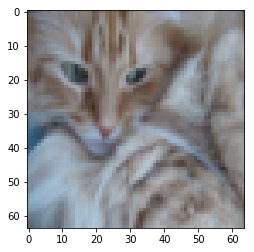

In [8]:
plt.imshow(X[2])

In [9]:
print("Number of train examples:", X.shape[0])
print("Number of test  examples:", Xtest.shape[0])
print("One image size:({}, {}, {})".
      format(X.shape[1], X.shape[1], 3))
print("train X shape:", X.shape)
print("train y shape:", y.shape)
print("test  X shape:", Xtest.shape)
print("test  y shape:", ytest.shape)

Number of train examples: 209
Number of test  examples: 50
One image size:(64, 64, 3)
train X shape: (209, 64, 64, 3)
train y shape: (1, 209)
test  X shape: (50, 64, 64, 3)
test  y shape: (1, 50)


In [10]:
X_flatten = X.reshape(X.shape[0], -1)  
Xtest_flatten = Xtest.reshape(Xtest.shape[0], -1)
X = X_flatten/255.
Xtest = Xtest_flatten/255.
print ("train X shape:", X.shape)
print ("test  X shape:", Xtest.shape)

train X shape: (209, 12288)
test  X shape: (50, 12288)


In [11]:
import joy
dnn = DeepNeuralNet_BGD([12288, 100, 50, 2], eta = 0.3, epochs = 164)  
dnn.fit(X, y.flatten())   
self = dnn.evaluate(X, y.flatten()) 
print('Accuracy self: {}%'.format(np.round(self, 2)))

Accuracy self: 87.56%


In [65]:
import joy
self_accuracy = []
test_accuracy = []
epoch_list = []
for epoch in range(160, 171):
    dnn = DeepNeuralNet_BGD([12288,100,50,2], eta=0.3,epochs=epoch)  
    dnn.fit(X, y.flatten())   
    self = dnn.evaluate(X, y.flatten()) 
    test = dnn.evaluate(Xtest, ytest.flatten())
    self_accuracy.append(self)
    test_accuracy.append(test)
    print('epochs:{}, Accuracy self:{}, test:{}%'.
          format(epoch, np.round(self, 2), test))

epochs:160, Accuracy self:97.13, test:54.0%
epochs:161, Accuracy self:95.22, test:54.0%
epochs:162, Accuracy self:98.09, test:66.0%
epochs:163, Accuracy self:92.82, test:46.0%
epochs:164, Accuracy self:96.17, test:78.0%
epochs:165, Accuracy self:90.43, test:42.0%
epochs:166, Accuracy self:93.78, test:76.0%
epochs:167, Accuracy self:83.25, test:40.0%
epochs:168, Accuracy self:83.25, test:78.0%
epochs:169, Accuracy self:77.51, test:38.0%
epochs:170, Accuracy self:72.25, test:74.0%


In [ ]:

'''
epochs:150, Accuracy self:87.08, test:74.0%
epochs:151, Accuracy self:79.9, test:38.0%
epochs:152, Accuracy self:94.26, test:78.0%
epochs:153, Accuracy self:83.73, test:38.0%
epochs:154, Accuracy self:92.34, test:78.0%
epochs:155, Accuracy self:86.6, test:46.0%
epochs:156, Accuracy self:94.74, test:74.0%
epochs:157, Accuracy self:93.3, test:56.00000000000001%
epochs:158, Accuracy self:95.69, test:70.0%
epochs:159, Accuracy self:92.34, test:56.00000000000001%
epochs:160, Accuracy self:96.17, test:70.0%
epochs:161, Accuracy self:93.78, test:50.0%
epochs:162, Accuracy self:96.17, test:70.0%
epochs:163, Accuracy self:96.17, test:60.0%
epochs:164, Accuracy self:97.61, test:68.0%
epochs:165, Accuracy self:96.65, test:57.99999999999999%
epochs:166, Accuracy self:96.65, test:70.0%
epochs:167, Accuracy self:95.22, test:56.00000000000001%
epochs:168, Accuracy self:96.65, test:72.0%
epochs:169, Accuracy self:97.13, test:60.0%
epochs:170, Accuracy self:97.13, test:64.0%
epochs:171, Accuracy self:95.69, test:57.99999999999999%
epochs:172, Accuracy self:96.65, test:70.0%
epochs:173, Accuracy self:95.69, test:54.0%
epochs:174, Accuracy self:96.17, test:74.0%
epochs:175, Accuracy self:91.39, test:48.0%
epochs:176, Accuracy self:90.43, test:78.0%
epochs:177, Accuracy self:86.12, test:42.0%
epochs:178, Accuracy self:93.78, test:80.0%
epochs:179, Accuracy self:86.12, test:36.0%
epochs:180, Accuracy self:87.08, test:78.0%
epochs:181, Accuracy self:81.34, test:34.0%
epochs:182, Accuracy self:78.47, test:74.0%
epochs:183, Accuracy self:76.56, test:34.0%
epochs:184, Accuracy self:77.03, test:76.0%
epochs:185, Accuracy self:74.16, test:38.0%
epochs:186, Accuracy self:78.47, test:76.0%
epochs:187, Accuracy self:75.12, test:34.0%
epochs:188, Accuracy self:79.43, test:78.0%
epochs:189, Accuracy self:72.25, test:34.0%
epochs:190, Accuracy self:84.69, test:78.0%
epochs:191, Accuracy self:81.34, test:44.0%
epochs:192, Accuracy self:89.95, test:72.0%
epochs:193, Accuracy self:82.3, test:42.0%
epochs:194, Accuracy self:89.47, test:72.0%
epochs:195, Accuracy self:87.08, test:44.0%
epochs:196, Accuracy self:93.3, test:68.0%
epochs:197, Accuracy self:89.0, test:50.0%
epochs:198, Accuracy self:92.82, test:74.0%
epochs:199, Accuracy self:89.95, test:52.0%
epochs:200, Accuracy self:95.22, test:64.0%
epochs:201, Accuracy self:92.34, test:50.0%
epochs:202, Accuracy self:95.22, test:68.0%
epochs:203, Accuracy self:94.26, test:52.0%
epochs:204, Accuracy self:95.69, test:60.0%
epochs:205, Accuracy self:95.69, test:57.99999999999999%
epochs:206, Accuracy self:96.65, test:62.0%
epochs:207, Accuracy self:96.17, test:56.00000000000001%
epochs:208, Accuracy self:96.65, test:57.99999999999999%
epochs:209, Accuracy self:95.22, test:54.0%
epochs:210, Accuracy self:97.13, test:62.0%
epochs:211, Accuracy self:95.69, test:52.0%
epochs:212, Accuracy self:97.13, test:68.0%
epochs:213, Accuracy self:93.3, test:48.0%
epochs:214, Accuracy self:96.17, test:68.0%
epochs:215, Accuracy self:92.82, test:52.0%
epochs:216, Accuracy self:94.74, test:70.0%
epochs:217, Accuracy self:92.82, test:50.0%
epochs:218, Accuracy self:96.65, test:68.0%
epochs:219, Accuracy self:91.87, test:54.0%
epochs:220, Accuracy self:94.26, test:70.0%
epochs:221, Accuracy self:92.82, test:48.0%
epochs:222, Accuracy self:94.74, test:74.0%
epochs:223, Accuracy self:86.6, test:38.0%
epochs:224, Accuracy self:87.56, test:72.0%
epochs:225, Accuracy self:79.9, test:36.0%
epochs:226, Accuracy self:75.12, test:74.0%
epochs:227, Accuracy self:77.03, test:34.0%
epochs:228, Accuracy self:80.86, test:76.0%
epochs:229, Accuracy self:75.12, test:30.0%
epochs:230, Accuracy self:77.99, test:76.0%
epochs:231, Accuracy self:76.08, test:38.0%
epochs:232, Accuracy self:81.82, test:70.0%
epochs:233, Accuracy self:84.21, test:48.0%
epochs:234, Accuracy self:86.6, test:70.0%
epochs:235, Accuracy self:85.17, test:52.0%
epochs:236, Accuracy self:87.08, test:74.0%
epochs:237, Accuracy self:84.21, test:46.0%
epochs:238, Accuracy self:86.12, test:72.0%
epochs:239, Accuracy self:84.21, test:50.0%
epochs:240, Accuracy self:85.65, test:72.0%
epochs:241, Accuracy self:79.9, test:44.0%
epochs:242, Accuracy self:74.64, test:74.0%
epochs:243, Accuracy self:77.03, test:34.0%
epochs:244, Accuracy self:80.86, test:72.0%
epochs:245, Accuracy self:84.69, test:48.0%
epochs:246, Accuracy self:89.95, test:66.0%
epochs:247, Accuracy self:88.52, test:54.0%
epochs:248, Accuracy self:90.91, test:64.0%
epochs:249, Accuracy self:88.04, test:54.0%
epochs:250, Accuracy self:90.43, test:60.0%
epochs:251, Accuracy self:90.91, test:56.00000000000001%
epochs:252, Accuracy self:90.43, test:68.0%
epochs:253, Accuracy self:91.39, test:56.00000000000001%
epochs:254, Accuracy self:90.43, test:64.0%
epochs:255, Accuracy self:91.39, test:54.0%
epochs:256, Accuracy self:92.34, test:57.99999999999999%
epochs:257, Accuracy self:90.91, test:57.99999999999999%
epochs:258, Accuracy self:90.91, test:62.0%
epochs:259, Accuracy self:92.34, test:60.0%
epochs:260, Accuracy self:91.87, test:60.0%
epochs:261, Accuracy self:92.34, test:66.0%
epochs:262, Accuracy self:92.82, test:64.0%
epochs:263, Accuracy self:90.43, test:57.99999999999999%
epochs:264, Accuracy self:91.87, test:64.0%
epochs:265, Accuracy self:90.43, test:52.0%
epochs:266, Accuracy self:87.56, test:72.0%
epochs:267, Accuracy self:82.3, test:44.0%
epochs:268, Accuracy self:79.9, test:74.0%
epochs:269, Accuracy self:79.43, test:38.0%
epochs:270, Accuracy self:77.99, test:70.0%
epochs:271, Accuracy self:75.12, test:38.0%
epochs:272, Accuracy self:67.94, test:78.0%
'''

In [ ]:
self_max = np.argmax(self_accuracy)
print()

In [ ]:
def backprop(self, Z, A, Y):
    # initialize empty lists to save E and dZ with None
    E  = [None for x in range(self.layers)]
    dZ = [None for x in range(self.layers)]
    # Get error at the output layer or the last layer
    ll = self.layers - 1
    error = Y - A[ll]
    E[ll] = error   
    dZ[ll] = error * self.g_prime[ll](Z[ll]) 
    # Begin from the back, from the next to last layer
    for i in range(self.layers-2, 0, -1):
        E[i]  = np.dot(self.W[i+1].T, E[i+1])
        dZ[i] = E[i] * self.g_prime[i](Z[i])
    # Adjust the weights 
    m = Y.shape[1]  # number of samples
    for i in range(ll, 0, -1):
        self.W[i] += self.eta * np.dot(dZ[i], A[i-1].T) / m
    return error

In [ ]:
def fit(self, X, y):
    self.cost_ = [] 
    self.m_samples = len(y)
    Y = joy.one_hot_encoding(y, self.net_arch[-1]) 

    for epoch in range(self.epochs): 
        A0 = np.array(X, ndmin=2).T  
        Y0 = np.array(Y, ndmin=2).T   

        Z, A = self.forpass(A0)          # for. pass
        cost = self.backprop(Z, A, Y0)   # back prop
        self.cost_.append(np.sqrt(np.sum(cost * cost)))
    return self

In [ ]:
# invoked by plot_decsion_regions() 
def predict(self, X):          
    Z, A2 = self.forpass(X)
    A2 = np.array(A2[len(A2)-1])
    return A2[-1] > 0.5

# used by DeepNeuralNet.evaluate()
def predict_(self, X): 
    A0 = np.array(X, ndmin=2).T         
    Z, A = self.forpass(A0)           
    return A[-1]     

## 학습 정리
- 다층 신경망 DeepNeuralNet 성능 테스트
- MNIST-Fashion 데이터 셋
- 고양이와 고양이가 아닌 데이터 분류


----------
Rejoice in the Lord always. I will say it again: Rejoice! (Ph4:4)